In [ ]:
from PIL import  Image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
np.random.seed(24)

In [ ]:
def unpickle(file):
    """load the cifar-10 data"""
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data
 
 
def load_cifar_10_data(data_dir, negatives=False):
 
    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)
 
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []
 
    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']
 
    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)
 
    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']
 
    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)
 
    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names
 
!wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
!tar -xzvf "/content/cifar-10-python.tar.gz"
cifar_10_dir = r"/content/cifar-10-batches-py"
 
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)

--2022-03-16 18:10:03--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.5MB/s    in 3.5s    

2022-03-16 18:10:07 (47.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def padding_function( img , ValuesOfPad: tuple ):
  H,W,C = img.shape
  Heigh_pad,width_pad         =  ValuesOfPad 
  # size of output image 
  H_pad =  H + 2*Heigh_pad
  W_pad =  W + 2*width_pad
  paddedImage = np.zeros([H_pad,W_pad,C])

  for ch in range(C) :
      paddedImage[Heigh_pad:-Heigh_pad, :width_pad ,ch   ] =  np.copy(img[:,:width_pad,ch][:,::-1])  
      paddedImage[Heigh_pad:-Heigh_pad, -width_pad :  ,ch ] =   np.copy(img[:,-width_pad:,ch][:,::-1])  

      # copying image in center
      paddedImage[Heigh_pad:-Heigh_pad , width_pad:-width_pad,ch] = np.copy(img[:,:,ch])
      paddedImage[:Heigh_pad,:,ch] = np.copy(paddedImage[Heigh_pad:2*Heigh_pad,:,ch][::-1]) #First two rows
      paddedImage[-Heigh_pad:,:,ch] = np.copy(paddedImage[-2*Heigh_pad:-Heigh_pad,:,ch][::-1]) #LAst two rows

  return paddedImage

**Convolution function:**

In [ ]:
def convolution( img   ,kernel , NonLinearFunc: str  ,padding: tuple = (0,0), stride: tuple = (1,1) ,  pad_bin: bool = 0  ):

  Heigh_k , Width_k , C  = kernel.shape
  H,W,C  = img.shape
  heigh_pad,Width_pad   =  padding
  heigh_stride,width_stride = stride
  ReLU  = lambda x: max(0,x)
  PReLu  = lambda x : np.where(x >= 0, x, 0.02 * x) # a = 0.02
  TanH  = lambda x : 2 / (1 + np.exp(-2*x)) - 1
  Sigmoid = lambda x : 1/ (1+np.exp(-x))

  ActivFunc = {
    'ReLU': ReLU,
    'Sigmoid': Sigmoid,
    'PReLu': PReLu,
    'TanH': TanH
  }

  let_NonLinearFunc = ActivFunc[NonLinearFunc]

  # Normalizing kernel values
  kernel = kernel / ((Heigh_k**2 )*(Width_k**2))

  H_pad = int( ( H - Heigh_k + 2*(heigh_pad)) / heigh_stride ) + 1
  W_pad = int( (W - Width_k + 2*(Width_pad)) / width_stride  ) + 1
  map_activ = np.zeros((H_pad , W_pad ))
  output = np.zeros((H_pad , W_pad ))
  
  
  # Padding 
  if pad_bin :
    im_pad  = padding_function(img,padding)
  else :
    im_pad = img

  count = 0
  for h in range(0,H,heigh_stride):                     
        for w in range(0,W,width_stride):                     
              count+=1
              StartVertical = h 
              StartHorizental = w
              End_Vertical = StartVertical + Heigh_k
              EndHorizental = StartHorizental + Width_k

              if ( StartHorizental < (W_pad - (Width_k) )) and ( StartVertical < (H_pad - Heigh_k) ):
                ImageSlice = im_pad[StartVertical:End_Vertical , StartHorizental:EndHorizental , :]
                ConvVal = np.multiply(ImageSlice,kernel) # taking one kernel at a time
                # sum on convolved channels 
                output[h,w] = np.sum(ConvVal) 
                map_activ[h,w] = let_NonLinearFunc(output[h,w])

  return map_activ

In [ ]:

kernel = np.random.rand(3,3,3)
im =  np.asarray(train_data[2])
im.shape

(32, 32, 3)

 Q1 Display the input image, the filter kernel and the output activation map.


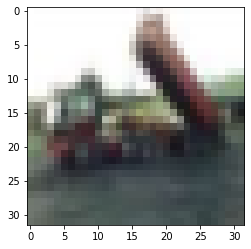

In [ ]:
plt.imshow(im)

In [ ]:
kernel

array([[[0.9600173 , 0.69951205, 0.99986729],
        [0.2200673 , 0.36105635, 0.73984099],
        [0.99645573, 0.31634698, 0.13654458]],

       [[0.38398001, 0.32051928, 0.36641475],
        [0.70965156, 0.90014243, 0.53411544],
        [0.24729376, 0.67180656, 0.56172911]],

       [[0.54255988, 0.8934476 , 0.84277955],
        [0.30601259, 0.63116978, 0.68023886],
        [0.97042756, 0.89356715, 0.94242586]]])

In [ ]:
convolution(im,kernel,NonLinearFunc = 'PReLu',padding=(2,2),pad_bin=1)

array([[52.89429789, 52.87114853, 52.77827617, ...,  0.        ,
         0.        ,  0.        ],
       [52.88490012, 52.90465651, 52.81910407, ...,  0.        ,
         0.        ,  0.        ],
       [52.88320927, 52.90657304, 52.85398846, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
convolution(im,kernel,NonLinearFunc = 'ReLU',padding=(2,2),pad_bin=1)

array([[52.89429789, 52.87114853, 52.77827617, ...,  0.        ,
         0.        ,  0.        ],
       [52.88490012, 52.90465651, 52.81910407, ...,  0.        ,
         0.        ,  0.        ],
       [52.88320927, 52.90657304, 52.85398846, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
convolution(im,kernel,NonLinearFunc = 'Sigmoid',padding=(2,2),pad_bin=1)

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
convolution(im,kernel,NonLinearFunc = 'TanH',padding=(2,2),pad_bin=1)

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Pooling function**

In [ ]:
def Poolingfunction(active_map ,SizeOfKernel: tuple = (2,2), func = 'Max',stride: tuple = (2,2)  ):
  

  max = lambda x : np.amax(x)
  height_Kernel,Width_kernel = SizeOfKernel
  
  avg = lambda x : np.sum(x) / (height_Kernel*Width_kernel)
  
  norm = lambda x : np.sqrt(np.sum(x**2))
  
  Pooling_functions ={'Max' : max ,'Avg':avg , 'L2_norm': norm }
  pool_func = Pooling_functions[func]
  H,W = active_map.shape
  heigh_stride,width_stride = stride


  H_out = int( ( H - height_Kernel )/heigh_stride ) + 1
  W_out = int( (W - Width_kernel )/width_stride ) + 1
  output = np.zeros([H_out,W_out])

  for h in range(0,H,heigh_stride):                     
      for w in range(0,W,width_stride):

        StartVertical = h 
        StartHorizental = w
        End_Vertical = StartVertical + height_Kernel
        EndHorizental = StartHorizental + Width_kernel

        if ( StartHorizental < (W_out - Width_kernel )) and ( StartVertical < (H_out - height_Kernel) ):

          # Slice the image for pooling    
          ImageSlice= active_map[StartVertical:End_Vertical , StartHorizental:EndHorizental ]
          output[h,w] = pool_func(ImageSlice[:,:])

  
  return output

Q2 Display the input activation map and the pooled output.

In [ ]:
active=convolution(im,kernel,NonLinearFunc = 'TanH',padding=(2,2),pad_bin=1)
print("shape of activation map ",active.shape)
active

shape of activation map  (34, 34)


array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:

pool=Poolingfunction(active,SizeOfKernel = (2,2),stride = (2,2))
print("shape of  pooled output ",pool.shape)
pool

shape of  pooled output  (17, 17)


array([[1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

**Convolution layer function**

In [ ]:
def Convolutionlayerfunction( img   ,kernel , NonLinearFunc: str  ,padding: tuple = (0,0), stride: tuple = (1,1) ,  pad_bin: bool = 0 ):
  Heigh_k , Width_k , Channel ,Channel_out  = kernel.shape
  heigh_stride,width_stride = stride
  heigh_pad,Width_pad   =  padding
  H,W,Channel  = img.shape

  H_out = int( ( H - Heigh_k + 2*(heigh_pad))/heigh_stride ) + 1
  W_out = int( (W - Width_k + 2*(Width_pad))/width_stride  ) + 1
  map_activ = np.zeros([H_out,W_out,Channel_out])

  for c in range(Channel_out) :
    map_activ[:,:,c] = convolution(img ,kernel[:,:,:,c],NonLinearFunc = NonLinearFunc ,padding = padding , stride = stride , pad_bin = pad_bin)

  return map_activ

Q 3 Display the input image or activation
maps, the filter kernels and the output activation maps.

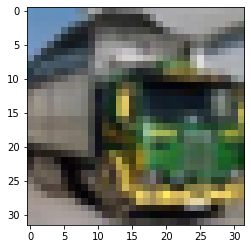

In [ ]:

im =  np.asarray(train_data[14])
plt.imshow(im)

In [ ]:
kernel = np.random.rand(3,3,3,10)
kernel

array([[[[6.42225481e-01, 6.14647634e-01, 2.27683254e-01,
          4.86031869e-01, 8.07219299e-01, 8.44220154e-01,
          5.34680866e-01, 7.57798050e-01, 4.99676886e-01,
          8.50327897e-01],
         [6.19696775e-01, 8.61614179e-01, 2.31697197e-01,
          4.02218415e-01, 6.24375062e-01, 1.43036706e-01,
          1.22798484e-01, 4.16829911e-01, 5.56882982e-01,
          9.41419175e-01],
         [4.09259023e-01, 7.36751449e-01, 9.95450674e-01,
          9.16664349e-01, 2.02327259e-03, 9.71331693e-01,
          8.89048177e-01, 6.99488606e-01, 9.75246685e-02,
          5.73429039e-01]],

        [[8.20037116e-01, 5.60891051e-01, 3.50762461e-01,
          5.43499756e-01, 8.79589092e-01, 1.14096565e-01,
          3.14388054e-02, 9.52810060e-01, 2.88743474e-01,
          4.41949171e-01],
         [2.59021532e-01, 5.96891444e-01, 6.55286046e-01,
          2.75695461e-01, 8.57972458e-01, 8.88724146e-01,
          2.85060591e-01, 6.59560419e-01, 9.72120259e-01,
          7.96874113

In [ ]:
OutputActivationMap=Convolutionlayerfunction(im,kernel,NonLinearFunc = 'ReLU',padding=(2,2),pad_bin=1)
OutputActivationMap

array([[[23.6936805 , 27.49175448, 19.95210433, ..., 21.03150786,
         22.72224662, 24.89570512],
        [23.70517851, 27.57004695, 20.00516769, ..., 21.05461893,
         22.77457241, 24.94803633],
        [23.60239468, 27.45171722, 19.86657252, ..., 20.95781093,
         22.64759497, 24.84658146],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[23.60454304, 27.54411591, 20.00708136, ..., 21.05994317,
         22.72607823, 24.87432006],
        [23.6107209 , 27.62730335, 20.0631869 , ..., 21.08670146,
         22.77144917, 24.92386952],
        [23.52120019, 27.4938708 , 19.92283823, ..., 20.99340086,
         22.64319993, 24.84121636],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

Q 3 Verify that the output of this function does
indeed have the expected size (W × H × C) as discussed in class.

In [ ]:
padding=(2,2)
stride = (1,1)
print("shape of  image ",im.shape)
print("shape of  kernel with Convolution layer",kernel.shape)
print("padding : ",padding)
print("stride by default " ,stride)
print("shape of  Output Activation Map ",OutputActivationMap.shape)


shape of  image  (32, 32, 3)
shape of  kernel with Convolution layer (3, 3, 3, 10)
padding :  (2, 2)
stride by default  (1, 1)
shape of  Output Activation Map  (34, 34, 10)


**Pooling layer function**

In [ ]:
def Poolinglayerfunction(img ,SizeOfKernel: tuple = (2,2), func = 'Max',stride: tuple = (2,2) ):

  Heigh_k,Width_k = SizeOfKernel
  H,W,C = img.shape
  heigh_stride,width_stride = stride

  H_out = int( ( H - Heigh_k )/heigh_stride ) + 1
  W_out = int( (W - Width_k )/width_stride ) + 1
  output = np.zeros([H_out,W_out,C])

  for c in range(C):
    output[:,:,c] = Poolingfunction(active_map = img[:,:,c] ,SizeOfKernel = SizeOfKernel , func = func,stride = stride  )

  return output

Q4 Display the input and output volumes.

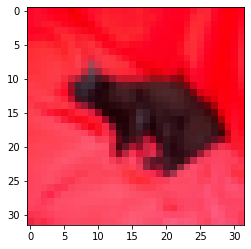

In [ ]:
im =  np.asarray(train_data[21])
plt.imshow(im)

In [ ]:
outputvolumes=Poolinglayerfunction(im ,SizeOfKernel = (2,2), func = 'Max',stride=(2,2) )
print("Shape of Pooling layer  output volumes :",outputvolumes.shape)
print("output volumes :",outputvolumes)

Shape of Pooling layer  output volumes : (16, 16, 3)
output volumes : [[[255.  15.  44.]
  [  0.   0.   0.]
  [254.  13.  42.]
  [  0.   0.   0.]
  [255.   2.  29.]
  [  0.   0.   0.]
  [250.   1.  17.]
  [  0.   0.   0.]
  [255.  15.  43.]
  [  0.   0.   0.]
  [254.  34.  47.]
  [  0.   0.   0.]
  [255.  28.  47.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[254.  16.  42.]
  [  0.   0.   0.]
  [253.  25.  43.]
  [  0.   0.   0.]
  [252.  33.  48.]
  [  0.   0.   0.]
  [253.  22.  43.]
  [  0.   0.   0.]
  [249.   9.  29.]
  [  0.   0.   0.]
  [252.  36.  46.]
  [  0.   0.   0.]
  [253.  36.  46.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.

**Flattening (unraveling) function**

In [ ]:
def Flattening(poolOutputVolume) :
  poolOutputVolume = poolOutputVolume.reshape(1,-1) 
  poolOutputVolume= poolOutputVolume.squeeze() 

  input_size = poolOutputVolume.size
  W = np.random.uniform(-1,1,size = (input_size , (1024) ))
  bias = np.random.rand(1, 1024 )

  output = np.dot(poolOutputVolume,W) + bias

  return output

Q5

In [ ]:
Flattening(outputvolumes) 

array([[  706.15756024,   807.42778473, -1162.45478203, ...,
          252.87308745, -2016.36934518,   965.2634018 ]])

**Multilayer Perceptron (MLP) function (Fully Connected)**

In [ ]:
def MLP(InputVector ,NumberOfHiddenLayers : int ,LayerSize : list , NonLinearFunc: str, OutputLayerSize : int):

  InputSize = InputVector.size
  
  ReLU  = lambda x: max(0,x)
  TanH  = lambda x : 2 / (1 + np.exp(-2*x)) - 1
  Sigmoid = lambda x : 1/ (1+np.exp(-x))
  Softmax = lambda x : np.exp(x) / np.sum(np.exp(x))
  PReLu  = lambda x : np.where(x >= 0, x, 2 * x) # a = 2

  ActivFunc = {
    'ReLU': ReLU,
    'Sigmoid': Sigmoid,
    'Softmax' : Softmax,
    'PReLu': PReLu,
    'TanH': TanH
  }

  activation_func = ActivFunc[NonLinearFunc]

  
  HiddenUnitsList = np.insert(LayerSize,0,InputSize)
  HiddenUnitsList = np.append(HiddenUnitsList,OutputLayerSize)

  Weights_list = []
  Biases_list  = []
  i = 0
  X = InputVector
  loop_length = len(HiddenUnitsList) -1

  for h_u in range(0,loop_length):

     Weights_list.append( np.random.uniform(-1,1,size = (HiddenUnitsList[h_u] , HiddenUnitsList[h_u + 1])) )
     Biases_list.append (  np.zeros((1, HiddenUnitsList[h_u + 1])) )
     output = np.dot(X,Weights_list[i]) + Biases_list[i]

     activated_output = activation_func(output)
     X =  activated_output
     i += 1
  softmax_output = Softmax(activated_output)

  return activated_output , softmax_output

Q6 Generate the output with and
without the softmax function applied to the output layer.

In [ ]:
input = np.arange(20)
hidden_list = [25,40,32]
NumberOfHiddenLayers = len(hidden_list)
output_size = 10
a,b = MLP(InputVector = input,NumberOfHiddenLayers = NumberOfHiddenLayers,LayerSize = hidden_list ,NonLinearFunc ='Sigmoid' , OutputLayerSize = output_size)
print("The output  without the softmax function applied to the output layer",a)
print("The output with  the softmax function applied to the output layer",b)

The output  without the softmax function applied to the output layer [[0.76309844 0.75243809 0.53695239 0.99673863 0.91019539 0.16187498
  0.3715395  0.19901669 0.96196488 0.59809373]]
The output with  the softmax function applied to the output layer [[0.11025859 0.10908944 0.08794243 0.13927754 0.12773086 0.06043721
  0.07453505 0.06272416 0.13451758 0.09348713]]


In [ ]:
!wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

--2022-03-16 18:10:13--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  41.9MB/s    in 5.3s    

2022-03-16 18:10:19 (30.8 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [ ]:
!tar -xzvf "/content/cifar-10-python.tar.gz"

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import pickle 

with open('/content/cifar-10-batches-py/data_batch_1', 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

with open('/content/cifar-10-batches-py/batches.meta', 'rb') as fo:
        dict_labels = pickle.load(fo, encoding='bytes')
        
training_data_vec = dict[b'data']
training_labels = dict[b'labels']
training_labels = np.asarray(training_labels)

In [ ]:
dict_labels

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

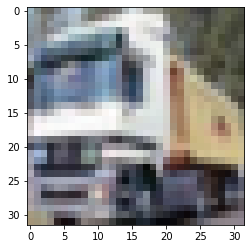

In [ ]:
index = np.argwhere(training_labels == 9)[0]

RedVectorChannel = training_data_vec[index].squeeze()[:1024]
GreenVectorChannel = training_data_vec[index].squeeze()[1024:2*1024]
BlueVectorChannel = training_data_vec[index].squeeze()[-1024:]

red_channel = RedVectorChannel.reshape(32,32)
green_channel = GreenVectorChannel.reshape(32,32)
blue_channel = BlueVectorChannel.reshape(32,32)

img = np.dstack((red_channel , green_channel , blue_channel))
plt.imshow(img)

In [ ]:
images = [] 
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 

for i in range(10):

  index = np.argwhere(training_labels == i)[0] # Find index of single image from each class
  channel = []
  for i in range(3):
    channel.append(training_data_vec[index].squeeze()[1024*i:1024*(i+1)].reshape(32,32))
  
  images.append(np.dstack(channel))

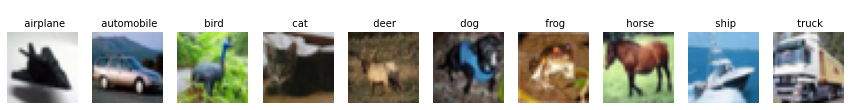

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()

for i,label in enumerate(labels):

    ax = fig.add_subplot(5, 10, i+1)
    ax.axis('off')
    ax.set_title(f'\n  {label} ', fontsize=10)
    ax.imshow(images[i])
plt.show()


**Feed-forward path**

In [ ]:
def Feedforwardpath( img):
  #Convolution layer with 16 kernels of size 3 × 3 × 3 and sigmoid activation.
  X = Convolutionlayerfunction( img = img  ,kernel = np.random.rand(3,3,3,16) , NonLinearFunc = 'Sigmoid' ) 
  print(X.shape)

  #Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
  X1 = Poolinglayerfunction(X ,SizeOfKernel = (2,2), func = 'Max',stride = (2,2) )
  print(X1.shape)

  # Convolution layer with 8 kernels of size 3 × 3 × C2 and sigmoid activation. What is the value of C2?.
  X2 = Convolutionlayerfunction( img = X1  ,kernel = np.random.rand(3,3,16,8) , NonLinearFunc = 'Sigmoid' ) 
  print(X2.shape)

  # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
  X3 = Poolinglayerfunction(X2 ,SizeOfKernel = (2,2), func = 'Max',stride = (2,2) )
  print(X3.shape)

  # A flattening layer. Note that the input size is fixed by the previous layer’s output. Your flattening matrix can be square, tall, or fat. Any choice is fine for this problem. Pick any one.
  X4 = Flattening(X3)
  print(X4.shape)

  # An MLP with one hidden layer that accepts as input the flattening layer output and maps it to 10 output nodes. Use sigmoid activation for the MLP.
  X5 ,softmax_X5 = MLP(X4 ,NumberOfHiddenLayers  =1 ,LayerSize  = [100] , NonLinearFunc= 'Sigmoid', OutputLayerSize = 10)
  print(X5.shape)

  return X5 , softmax_X5 ,X4

Q 7 Verify that your composition of function accepts and image input and outputs a vector.

In [ ]:
a,b,c = Feedforwardpath(images[1])

(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)


Q8 (a) Choose an image from each of the 10 classes and display the output vector for each case. Do you
see any trend in the output vectors?

In [ ]:
for i in range(10):
  print(f"Image {i} :")
  FinalLayer,Softmax , FlattenedOutput = Feedforwardpath(images[i])
  print(f"Final Layer 10 dimensional vector for class {labels[i]} is {FinalLayer}")
  print("****************************************************************************")

Image 0 :
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
Final Layer 10 dimensional vector for class airplane is [[2.79264671e-01 5.19622986e-01 9.99586328e-01 2.65145959e-03
  5.00826071e-01 7.84957633e-01 1.07850542e-04 6.40232929e-04
  9.99975753e-01 1.32250749e-01]]
****************************************************************************
Image 1 :
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
Final Layer 10 dimensional vector for class automobile is [[0.99996144 0.99999065 0.03928545 0.00160388 0.25487002 0.9901788
  0.00287506 0.96355867 0.00146254 0.1702517 ]]
****************************************************************************
Image 2 :
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
Final Layer 10 dimensional vector for class bird is [[7.81706114e-01 2.27935954e-01 3.22746591e-03 8.25627077e-01
  9.97903615e-01 7.59764512e-01 7.00235660e-05 9.97896606e-01
  3.55719036e-01 9.09830631e-01]]
*********************

Q 8 (b) Does a randomly initialized network show any discriminability? Visualize the bottleneck layer
(output of flattening layer) using builtin tSNE plots. Choose three images per class. If you are
wondering about this question, check out the Deep Image Prior paper.

In [ ]:
imge = [] 
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 

for i in range(10):

  index = np.argwhere(training_labels == i)[:3].squeeze() # Find index of single image from each class
  for j in index:
    
    channel = []
    for i in range(3):
      channel.append(training_data_vec[j].squeeze()[1024*i:1024*(i+1)].reshape(32,32))
    
    imge.append(np.dstack(channel))

In [ ]:
for i in range(10):
  
  FinalLayer,Softmax , FlattenedOutput = Feedforwardpath(images[i])

(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)


In [ ]:
BottleNeckLayerOutputs = np.zeros((30,1024))

In [ ]:
FinalLayer,Softmax , FlattenedOutput = Feedforwardpath(imge[1])
BottleNeckLayerOutputs[0,:] = np.copy(FlattenedOutput)


(30, 30, 16)
(15, 15, 16)
(13, 13, 8)
(6, 6, 8)
(1, 1024)
(1, 10)
